In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from dateutil.parser import isoparse
from ta import momentum, trend, volatility, volume

from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Optional: ensures that the line width doesn't truncate output

In [2]:
file = "daily_archives/daily_trading_data_2025-05-19.csv"
ticker = 'UNH' # symbol to analyze
start_time = '2025-05-19 15:20:00'
end_time = '2025-05-19 22:00:00'
freq = '120s'

df_daily = pd.read_csv(file)

df_daily["TimeStamp"] = df_daily["TimeStamp"].apply(isoparse)

df_daily = df_daily[(df_daily.TimeStamp >= start_time) & (df_daily.TimeStamp <= end_time)]

print(df_daily.info(), '\n')

print('Number of unique rows:\n', df_daily.drop_duplicates().shape[0], '\n')
print(df_daily.nunique(), '\n')

df_daily


<class 'pandas.core.frame.DataFrame'>
Index: 1183074 entries, 105629 to 1288800
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   ConId       1183074 non-null  int64         
 1   Symbol      1183074 non-null  object        
 2   SecType     1183074 non-null  object        
 3   Exchange    1183074 non-null  object        
 4   Currency    1183074 non-null  object        
 5   Bid_price   1183074 non-null  float64       
 6   TimeStamp   1183074 non-null  datetime64[ns]
 7   Ask_price   1183074 non-null  float64       
 8   Last_price  1183074 non-null  float64       
 9   Volume      1183074 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 99.3+ MB
None 

Number of unique rows:
 954945 

ConId              8
Symbol             8
SecType            1
Exchange           1
Currency           1
Bid_price       5040
TimeStamp     258894
Ask_price       50

,ConId,Symbol,SecType,Exchange,Currency,Bid_price,TimeStamp,Ask_price,Last_price,Volume
105629,13272,UNH,STK,SMART,USD,305.64,2025-05-19 15:20:00.066461,305.94,305.80,35969.0
105631,320227571,QQQ,STK,SMART,USD,513.94,2025-05-19 15:20:00.066461,513.98,513.97,22962.0
105632,76792991,TSLA,STK,SMART,USD,335.36,2025-05-19 15:20:00.302963,335.54,335.41,62302.0
105633,320227571,QQQ,STK,SMART,USD,513.94,2025-05-19 15:20:00.066461,513.98,513.97,22962.0
105637,320227571,QQQ,STK,SMART,USD,513.94,2025-05-19 15:20:00.066461,513.98,513.97,22962.0
...,...,...,...,...,...,...,...,...,...,...
1288719,602261424,NVDL,STK,SMART,USD,53.11,2025-05-19 21:59:59.932761,53.18,53.06,178610.0
1288723,72539702,TQQQ,STK,SMART,USD,71.64,2025-05-19 21:59:59.526876,71.66,71.66,700401.0
1288737,15547841,TLT,STK,SMART,USD,86.02,2025-05-19 21:59:59.932761,86.04,86.05,441532.0
1288757,15547841,TLT,STK,SMART,USD,86.02,2025-05-19 21:59:59.932761,86.04,86.05,441532.0


In [3]:
def ts_rate(ts_series):
    # Compute the duration in seconds between the max and min timestamps
    duration = (ts_series.max() - ts_series.min()).total_seconds()
    if duration == 0:
        # If duration is zero, return 0 or you can choose to return float('nan')
        return 0  
    return ts_series.nunique() / duration

# Group by 'Symbol' and compute the rate for the TS_Last_price column
rates = df_daily.groupby('Symbol')['TimeStamp'].apply(ts_rate).reset_index(name='TimeStamps_per_sec')

print("Number of TimeStamps entries per second per Symbol:")
rates

Number of TimeStamps entries per second per Symbol:


,Symbol,TimeStamps_per_sec
0,NVDA,4.066467
1,NVDL,1.947315
2,PLTR,3.456943
3,QQQ,3.913522
4,TLT,0.858254
5,TQQQ,2.807364
6,TSLA,4.697906
7,UNH,2.845016


In [4]:
def last_price_rate(group):
    # Ensure the group is sorted by TimeStamp
    group = group.sort_values('TimeStamp')
    
    # Create a boolean Series that is True when the price changes compared to the previous row
    # Note: The first row is automatically flagged, so subtract one if that isn’t desired.
    changes = group['Last_price'].ne(group['Last_price'].shift())
    change_count = changes.sum() 

    # Calculate how much time (in seconds) this group spans
    duration = (group['TimeStamp'].max() - group['TimeStamp'].min()).total_seconds()
    return change_count / duration

# Compute the rate per ticker by grouping by 'Symbol'
rates = df_daily.groupby('Symbol').apply(last_price_rate).reset_index(name='LastPriceRate')

print("Average number of Last Price changes per second per Symbol:")
rates

Average number of Last Price changes per second per Symbol:


C:\Users\Alienware\AppData\Local\Temp\ipykernel_35084\3663967838.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rates = df_daily.groupby('Symbol').apply(last_price_rate).reset_index(name='LastPriceRate')


,Symbol,LastPriceRate
0,NVDA,2.162282
1,NVDL,0.420780
2,PLTR,2.002371
3,QQQ,1.216882
4,TLT,0.248180
5,TQQQ,0.903397
6,TSLA,3.186508
7,UNH,2.162554


In [5]:
# count, mean, standard deviation, minimum, and maximum for Last_price.
stats_last = df_daily.groupby('Symbol').agg(
    count_last_price=('Last_price', 'count'),
    mean_last_price=('Last_price', 'mean'),
    std_last_price=('Last_price', 'std'),
    min_last_price=('Last_price', 'min'),
    max_last_price=('Last_price', 'max')
)
print("Last Price Statistics by Symbol:")
stats_last

Last Price Statistics by Symbol:


,count_last_price,mean_last_price,std_last_price,min_last_price,max_last_price
Symbol,,,,,
NVDA,186327,134.998417,0.568236,131.74,135.87
NVDL,99575,52.674460,0.469123,50.12,53.38
PLTR,153532,126.077865,0.678331,123.40,127.77
QQQ,190555,520.022192,1.659124,513.57,522.52
TLT,65099,85.531299,0.329910,84.75,86.12
TQQQ,160383,70.787409,0.692605,68.14,71.85
TSLA,201813,339.606398,1.890956,333.50,343.00
UNH,125790,309.370141,4.988202,297.25,316.25


In [6]:
# count, mean, standard deviation, minimum, and maximum for Volume.
stats_volume = df_daily.groupby('Symbol').agg(
    count_volume=('Volume', 'count'),
    mean_volume=('Volume', 'mean'),
    std_volume=('Volume', 'std'),
    min_volume=('Volume', 'min'),
    max_volume=('Volume', 'max')
)
print("\nVolume Statistics by Symbol:")
stats_volume


Volume Statistics by Symbol:


,count_volume,mean_volume,std_volume,min_volume,max_volume
Symbol,,,,,
NVDA,186327,1.074446e+06,421607.748263,135293.0,1744175.0
NVDL,99575,1.205791e+05,38761.325546,32487.0,178610.0
PLTR,153532,4.047277e+05,175027.357597,34393.0,707657.0
QQQ,190555,2.720968e+05,130492.981777,22962.0,502125.0
TLT,65099,2.590416e+05,102667.763202,52742.0,441532.0
TQQQ,160383,4.288865e+05,163203.674636,73342.0,700401.0
TSLA,201813,4.886610e+05,197949.439743,62302.0,822037.0
UNH,125790,3.437788e+05,149638.783492,35969.0,605398.0


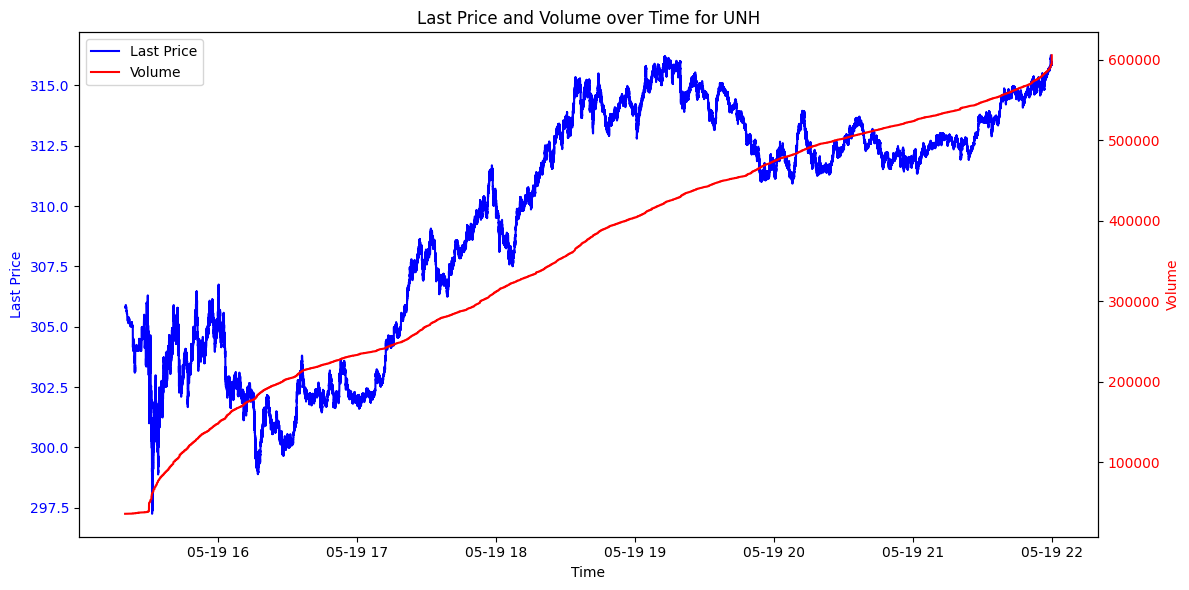

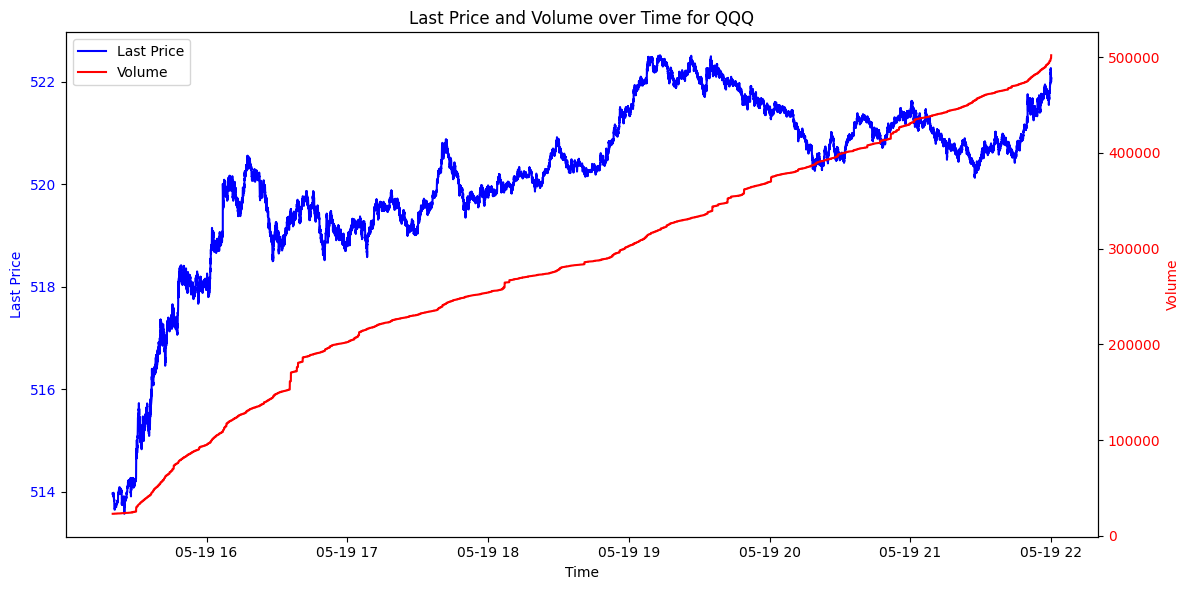

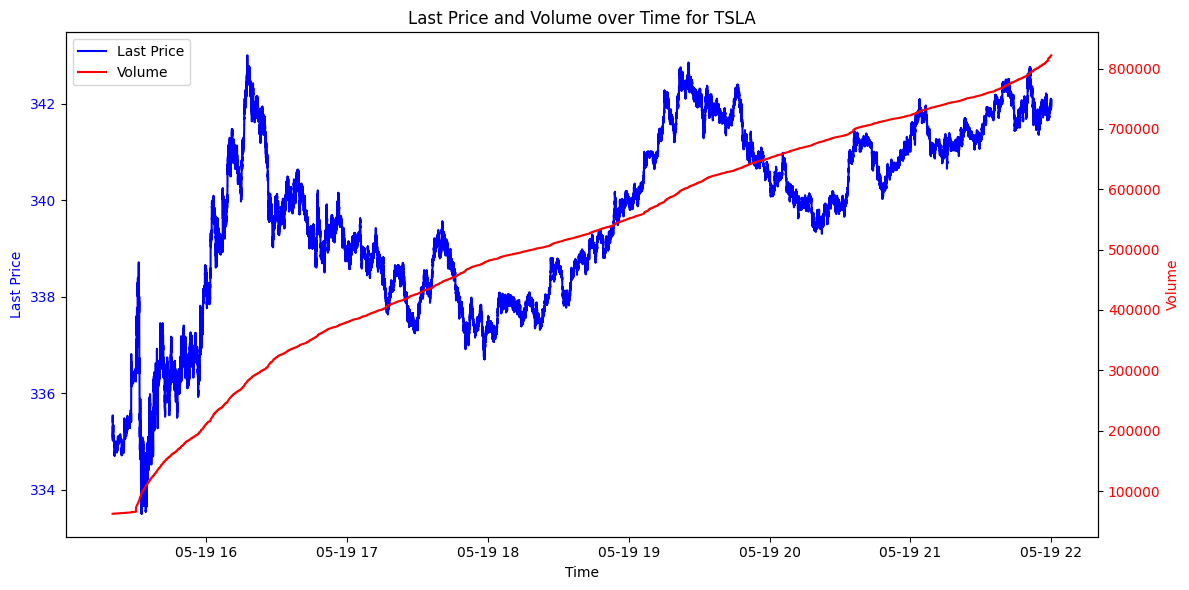

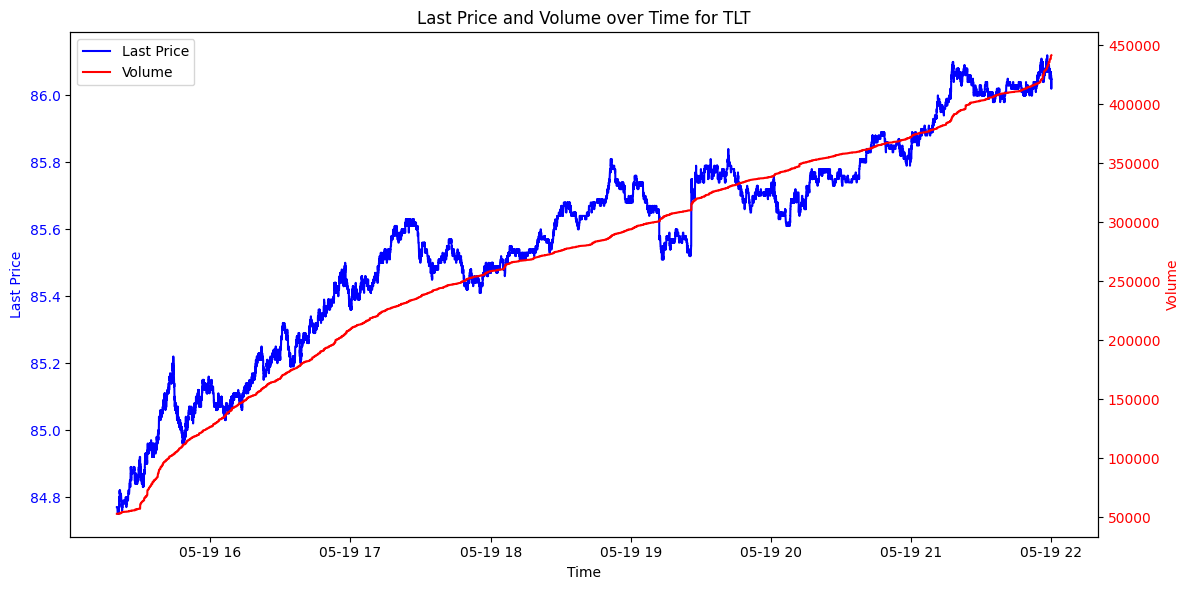

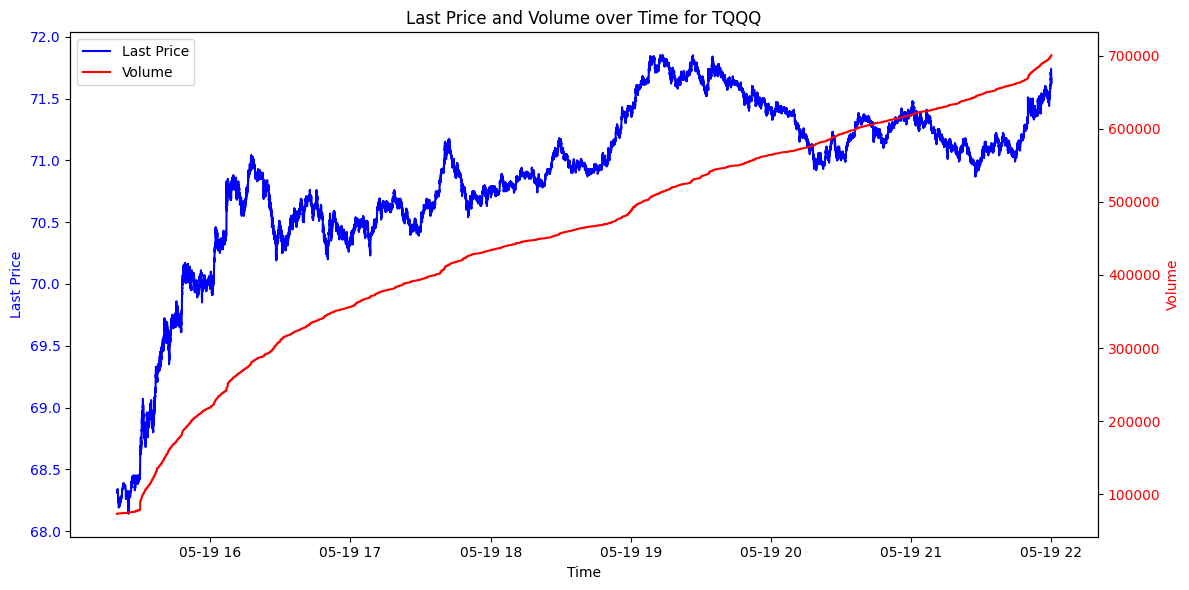

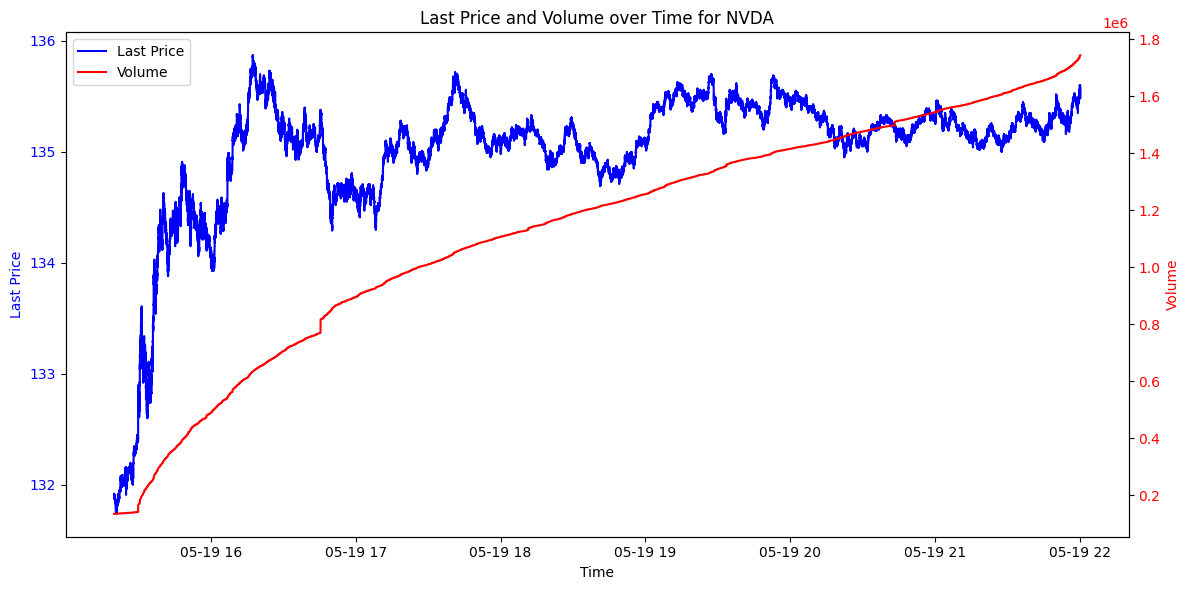

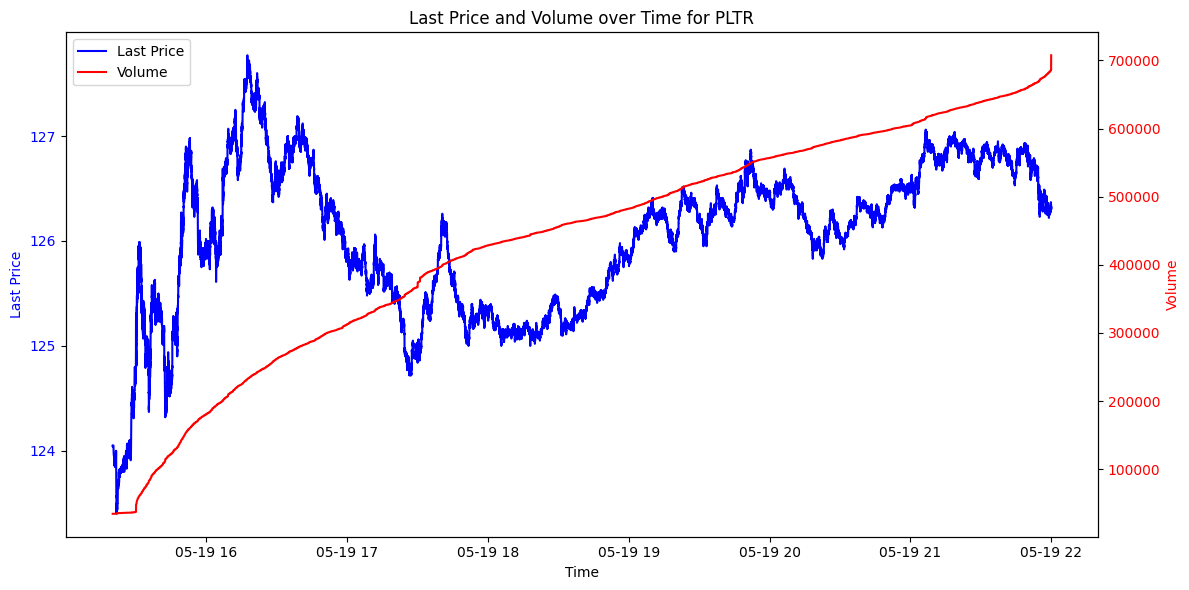

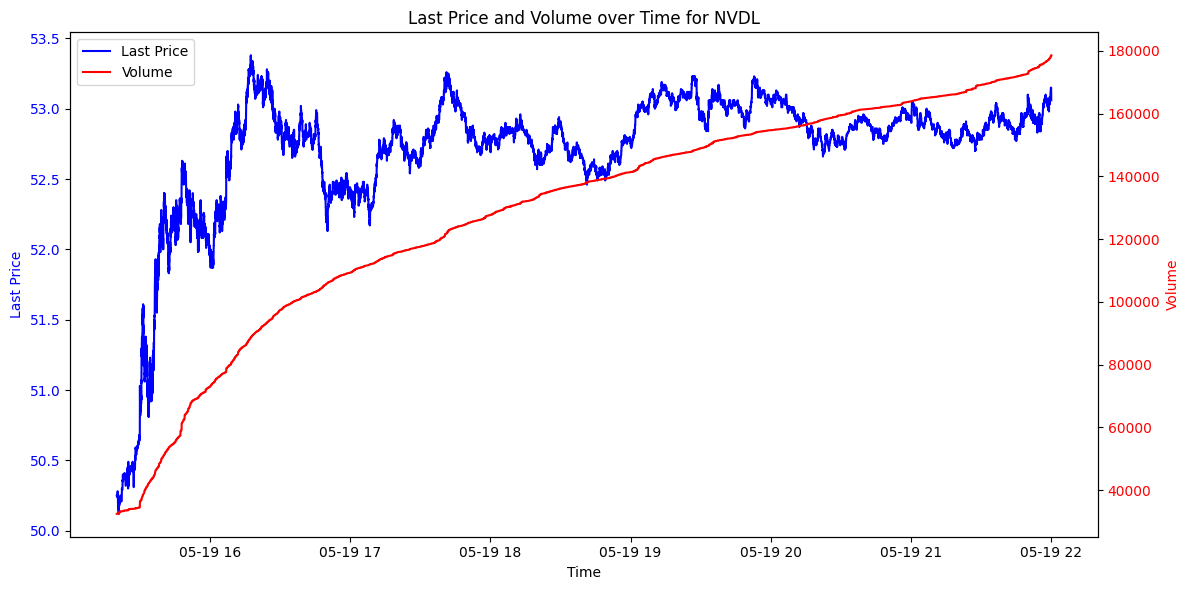

In [7]:
# Get all unique symbols.
symbols = df_daily['Symbol'].unique()


for sym in symbols:
    # Filter the data for the specific symbol
    df_sym = df_daily[df_daily['Symbol'] == sym]
    
    # Create a new figure and first axis for Last_price.
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot Last_price over time (using TS_Last_price).
    lns1 = ax1.plot(df_sym['TimeStamp'], df_sym['Last_price'], 
                    label='Last Price', color='blue')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Last Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create a twin Axes sharing the same x-axis for Volume.
    ax2 = ax1.twinx()
    lns2 = ax2.plot(df_sym['TimeStamp'], df_sym['Volume'],
                    label='Volume', color='red')
    ax2.set_ylabel('Volume', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Optionally, combine legends from both axes.
    lns = lns1 + lns2
    labels = [l.get_label() for l in lns]
    ax1.legend(lns, labels, loc='upper left')
    
    # Set a title and a bit of margin if desired.
    plt.title(f'Last Price and Volume over Time for {sym}')
    plt.tight_layout()
    plt.show()


In [8]:
# # Loop over each symbol
# for sym in symbols:
#     # Filter data for the specific symbol
#     df_sym = df_daily[df_daily['Symbol'] == sym]
    
#     # Create a new figure for the boxplot
#     plt.figure(figsize=(10,6))
    
#     # # Option 1: Using a single-variable boxplot
#     sns.boxplot(x=df_sym['Last_price'])
#     plt.xlabel('Last Price')
    
#     # Option 2 (if you prefer to show the symbol category):  
#     # sns.boxplot(x='Symbol', y='Last_price', data=df_sym)
#     # This will display the symbol on the x-axis (though there is only one category).
    
#     plt.title(f'Distribution of Last Price for {sym}')
#     plt.tight_layout()
#     plt.show()


In [9]:
# # Loop over each symbol and create an individual histogram.
# for sym in symbols:
#     df_sym = df_daily[df_daily['Symbol'] == sym]
#     plt.figure(figsize=(10, 6))
    
#     # Option 1: Using Matplotlib's plt.hist
#     plt.hist(df_sym['Last_price'], bins=30, color='steelblue', edgecolor='black')
    
#     # Option 2: Using Seaborn's histplot (uncomment if you prefer)
#     # sns.histplot(df_sym['Last_price'], bins=30, color='steelblue', edgecolor='black')
    
#     plt.xlabel('Last Price')
#     plt.ylabel('Frequency')
#     plt.title(f'Histogram of Last Price for {sym}')
#     plt.tight_layout()
#     plt.show()


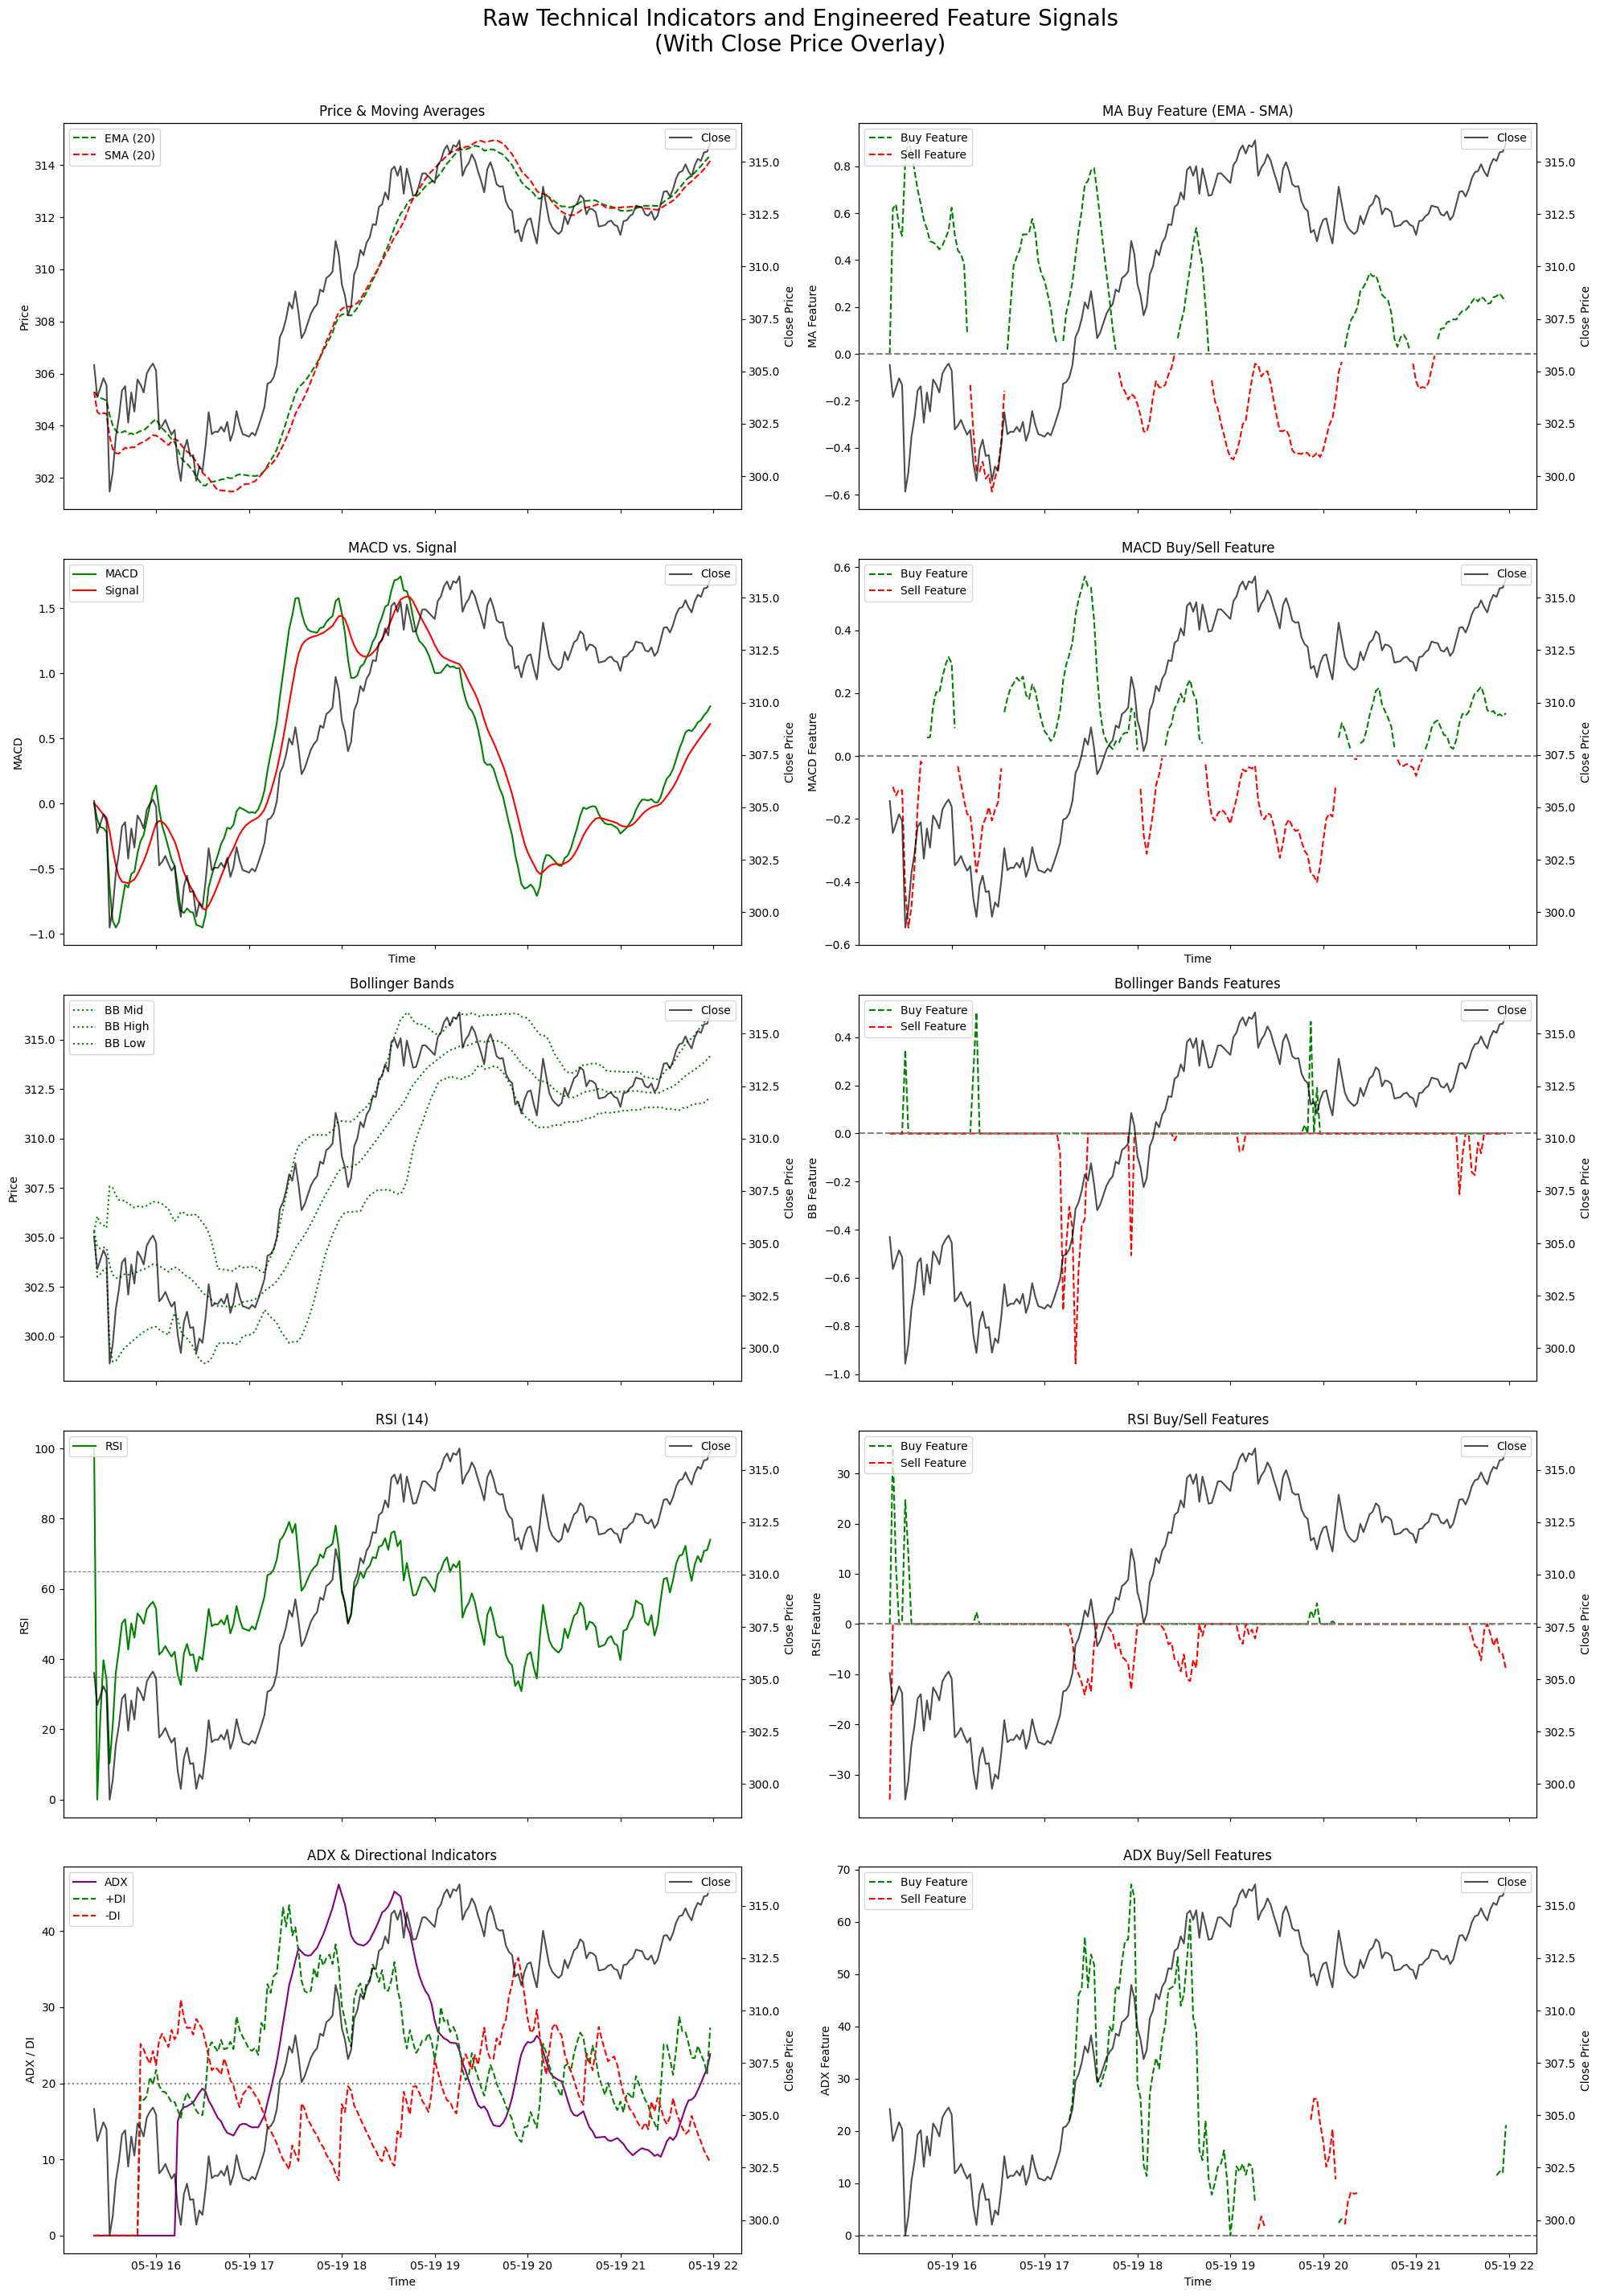

In [15]:
# Set the TimeStamp as the index (required for resampling).
if df_daily.index.name != "TimeStamp" and "TimeStamp" in df_daily.columns:
    df_daily.set_index("TimeStamp", inplace=True)


# --- Group by Symbol and Resample ---
ohlc_by_symbol = {}

# A helper function to aggregate volume.
# being "Volume" a cumulative (running) total for the day, we cannot simply sum the values over the candle period
# we need to compute the difference between the last and first volume values in each resampled interval
def volume_diff(x):
    # If there's only one record in the bucket, the traded volume is 0.
    if len(x) < 2:
        return 0
    return x.iloc[-1] - x.iloc[0]

for symbol, group in df_daily.groupby("Symbol"):
    # Resample the 'Last_price' per symbol to compute OHLC candles for the defined interval.
    ohlc = group["Last_price"].resample(freq).ohlc()
    
    # Use the custom aggregation for cumulative volume:
    # Calculate the difference between the last and first tick of each candle.
    if "Volume" in group.columns:
        ohlc["volume"] = group["Volume"].resample(freq).agg(volume_diff)


    # Optionally, add the Symbol as a column for easier identification.
    ohlc["symbol"] = symbol

    # ================================
    # Compute Technical Indicators
    # ================================
    
    # Moving Averages: 20-period SMA and EMA from the "close" price.
    ohlc["sma_20"] = ohlc["close"].rolling(window=20, min_periods=1).mean()
    ohlc["ema_20"] = ohlc["close"].ewm(span=20, adjust=False).mean()

    # MACD: using standard parameters (fast=12, slow=26, signal=9)
    macd_indicator = trend.MACD(close=ohlc["close"], window_fast=12, window_slow=26, window_sign=9, fillna=True)
    ohlc["macd"] = macd_indicator.macd()           # MACD line
    ohlc["macd_signal"] = macd_indicator.macd_signal()  # Signal line
    ohlc["macd_diff"] = macd_indicator.macd_diff()      # Histogram

    # Bollinger Bands: 20-period moving average with 2 standard deviations.
    bb_indicator = volatility.BollingerBands(close=ohlc["close"], window=20, window_dev=2, fillna=True)
    ohlc["bb_mavg"] = bb_indicator.bollinger_mavg()   # Middle band
    ohlc["bb_hband"] = bb_indicator.bollinger_hband()   # Upper band
    ohlc["bb_lband"] = bb_indicator.bollinger_lband()   # Lower band
    
    # RSI: 14-period (using the close price)
    rsi_indicator = momentum.RSIIndicator(close=ohlc["close"], window=14, fillna=True)
    ohlc["rsi"] = rsi_indicator.rsi()
    
    # Average True Range (ATR): 14-period ATR using high, low, close.
    # Note: Here we use the OHLC prices that were derived from Last_price, which might not capture the full high/low variability.
    atr_indicator = volatility.AverageTrueRange(high=ohlc["high"], low=ohlc["low"], close=ohlc["close"], window=14, fillna=True)
    ohlc["atr"] = atr_indicator.average_true_range()
    
    # ADX: 14-period ADX indicator for trend strength.
    adx_indicator = trend.ADXIndicator(high=ohlc["high"], low=ohlc["low"], close=ohlc["close"], window=14, fillna=True)
    ohlc["adx"] = adx_indicator.adx()
    ohlc["plus_di"] = adx_indicator.adx_pos()
    ohlc["minus_di"] = adx_indicator.adx_neg()
    
    # On-Balance Volume (OBV):
    # OBV calculates cumulative volume by adding volume on up moves and subtracting on down moves.
    obv_indicator = volume.OnBalanceVolumeIndicator(close=ohlc["close"], volume=ohlc["volume"], fillna=True)
    ohlc["obv"] = obv_indicator.on_balance_volume()
    
    # ================================
    # Generate Trading Features, from Buy, Sell, Hold Signals
    # ================================

    # 1. Moving Averages feature:
    # Continuous signal as the raw difference between EMA and SMA.
    ohlc["ma_buy_feature"] = ohlc["ema_20"] - ohlc["sma_20"]

    # 2. MACD feature:
    # The continuous signal is the difference between the MACD and its signal line.
    ohlc["macd_buy_feature"] = ohlc["macd"] - ohlc["macd_signal"]

    # 3. Bollinger Bands feature:
    # If the close is below the lower band, the buy signal is (lower band - close).
    # Otherwise, no signal (0).
    ohlc["bb_buy_feature"] = np.where(ohlc["close"] < ohlc["bb_lband"], ohlc["bb_lband"] - ohlc["close"], 0)
    
    # If the close is above the upper band, the sell signal is - (close - upper band)
    # Notice the negative sign to indicate a selling (downward) move.
    ohlc["bb_sell_feature"] = np.where(ohlc["close"] > ohlc["bb_hband"], -(ohlc["close"] - ohlc["bb_hband"]), 0)

    
    # 4. RSI feature:
    # For RSI, when the value is below eg 30, the buy signal is (30 - RSI) (a positive number).
    # When RSI is above eg 70, the sell signal is -(RSI - 70) (a negative number).
    # Otherwise, the value is 0.
    low_rsi = 35
    high_rsi = 65
    ohlc["rsi_buy_feature"] = np.where(ohlc["rsi"] < low_rsi, low_rsi - ohlc["rsi"], 0)
    ohlc["rsi_sell_feature"] = np.where(ohlc["rsi"] > high_rsi, -(ohlc["rsi"] - high_rsi), 0)


    # 5. ADX with Directional Indicators:
    # When ADX is above a threshold (20), we use the difference between plus_di and minus_di.
    ohlc["adx_buy_feature"] = np.where(
        (ohlc["plus_di"] > ohlc["minus_di"]) & (ohlc["adx"] >= 20),
        (ohlc["plus_di"] - ohlc["minus_di"]) * (ohlc["adx"] / 20),
        np.nan
    )
    ohlc["adx_sell_feature"] = np.where(
        (ohlc["minus_di"] > ohlc["plus_di"]) & (ohlc["adx"] >= 20),
        (ohlc["minus_di"] - ohlc["plus_di"]) * (ohlc["adx"] / 20),
        np.nan
    )

    # 6. OBV feature:
    # Here, we use the raw change (difference) in OBV as a continuous indicator.
    # A positive difference suggests buying pressure, negative indicates selling.
    ohlc["obv_buy_feature"] = ohlc["obv"].diff()


    # -------------------------------
    # Calculate the Continuous "True Signal", shifting the pct_change, in order to use our features to predict the future pct_change
    # -------------------------------
    
    # Compute the percentage change in the closing price.
    ohlc["price_pct_change"] = ohlc["close"].pct_change().shift(-1)

    # List all columns that end with '_feature'
    feature_cols = [col for col in ohlc.columns if col.endswith('_feature')]
    
    # target
    target_col = ['price_pct_change']

    columns = feature_cols + target_col
    
    # Save the filtered DataFrame into the dictionary 
    ohlc_by_symbol[symbol] = ohlc[columns]



    # -------------------------------
    # Visualizations
    # -------------------------------   

    if (ohlc['symbol'] == ticker).all():  # Visualization only for the selected ticker
    
        # Create a grid of 5 rows x 2 columns.
        fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 30), sharex=True)
        fig.suptitle("Raw Technical Indicators and Engineered Feature Signals\n(With Close Price Overlay)", fontsize=20)
    
        # =======================================================
        # Row 0: Moving Averages
        # =======================================================
        # Left panel: Raw moving averages: EMA and SMA.
        ax00 = axs[0, 0]
        ax00.plot(ohlc.index, ohlc["ema_20"], label="EMA (20)", linestyle="--", color="green")
        ax00.plot(ohlc.index, ohlc["sma_20"], label="SMA (20)", linestyle="--", color="red")
        ax00.set_ylabel("Price")
        ax00.legend(loc="upper left")
        ax00.set_title("Price & Moving Averages")
        # Secondary axis: Close Price.
        ax00_twin = ax00.twinx()
        ax00_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", alpha=0.7)
        ax00_twin.set_ylabel("Close Price")
        ax00_twin.legend(loc="upper right")
        
        # Right panel: Engineered MA feature (EMA - SMA).
        ax01 = axs[0, 1]
        ax01.plot(ohlc.index, ohlc["ma_buy_feature"].where(ohlc["ma_buy_feature"] >= 0), 
                  label="Buy Feature", color="green", linestyle="--")
        ax01.plot(ohlc.index, ohlc["ma_buy_feature"].where(ohlc["ma_buy_feature"] < 0), 
                  label="Sell Feature", color="red", linestyle="--")
        ax01.axhline(0, color="gray", linestyle="--")
        ax01.set_ylabel("MA Feature")
        ax01.legend(loc="upper left")
        ax01.set_title("MA Buy Feature (EMA - SMA)")
        # Secondary axis: Close Price.
        ax01_twin = ax01.twinx()
        ax01_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", alpha=0.7)
        ax01_twin.set_ylabel("Close Price")
        ax01_twin.legend(loc="upper right")
    
        # =======================================================
        # Row 1: MACD
        # =======================================================
        # Left panel: Raw MACD and its Signal line.
        ax10 = axs[1, 0]
        ax10.plot(ohlc.index, ohlc["macd"], label="MACD", color="green")
        ax10.plot(ohlc.index, ohlc["macd_signal"], label="Signal", color="red")
        ax10.set_ylabel("MACD")
        ax10.legend(loc="upper left")
        ax10.set_title("MACD vs. Signal")
        ax10.set_xlabel("Time")
        # Secondary axis: Close Price.
        ax10_twin = ax10.twinx()
        ax10_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", alpha=0.7)
        ax10_twin.set_ylabel("Close Price")
        ax10_twin.legend(loc="upper right")
        
        # Right panel: Engineered MACD feature.
        ax11 = axs[1, 1]
        ax11.plot(ohlc.index, ohlc["macd_buy_feature"].where(ohlc["macd_buy_feature"] >= 0),
                  label="Buy Feature", color="green", linestyle="--")
        ax11.plot(ohlc.index, ohlc["macd_buy_feature"].where(ohlc["macd_buy_feature"] < 0),
                  label="Sell Feature", color="red", linestyle="--")
        ax11.axhline(0, color="gray", linestyle="--")
        ax11.set_ylabel("MACD Feature")
        ax11.legend(loc="upper left")
        ax11.set_title("MACD Buy/Sell Feature")
        ax11.set_xlabel("Time")
        # Secondary axis: Close Price.
        ax11_twin = ax11.twinx()
        ax11_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", alpha=0.7)
        ax11_twin.set_ylabel("Close Price")
        ax11_twin.legend(loc="upper right")
        
        # =======================================================
        # Row 2: Bollinger Bands
        # =======================================================
        # Left panel: Raw Bollinger Bands (Mid, High, Low) with Close.
        ax20 = axs[2, 0]
        ax20.plot(ohlc.index, ohlc["bb_mavg"], label="BB Mid", linestyle=":", color="green")
        ax20.plot(ohlc.index, ohlc["bb_hband"], label="BB High", linestyle=":", color="green")
        ax20.plot(ohlc.index, ohlc["bb_lband"], label="BB Low", linestyle=":", color="green")
        ax20.set_ylabel("Price")
        ax20.legend(loc="upper left")
        ax20.set_title("Bollinger Bands")
        # Secondary axis: Close Price.
        ax20_twin = ax20.twinx()
        ax20_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", alpha=0.7)
        ax20_twin.set_ylabel("Close Price")
        ax20_twin.legend(loc="upper right")
        
        # Right panel: Bollinger Bands Features.
        ax21 = axs[2, 1]
        # Now, the buy feature is positive (green) and the sell feature is negative (red).
        ax21.plot(ohlc.index, ohlc["bb_buy_feature"], label="Buy Feature", color="green", linestyle="--")
        ax21.plot(ohlc.index, ohlc["bb_sell_feature"], label="Sell Feature", color="red", linestyle="--")
        ax21.axhline(0, color="gray", linestyle="--")
        ax21.set_ylabel("BB Feature")
        ax21.legend(loc="upper left")
        ax21.set_title("Bollinger Bands Features")
        # Secondary axis: Close Price.
        ax21_twin = ax21.twinx()
        ax21_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", alpha=0.7)
        ax21_twin.set_ylabel("Close Price")
        ax21_twin.legend(loc="upper right")

        
        # =======================================================
        # Row 3: RSI
        # =======================================================
        # Left panel: Raw RSI with thresholds.
        ax30 = axs[3, 0]
        ax30.plot(ohlc.index, ohlc["rsi"], label="RSI", color="green")
        ax30.axhline(low_rsi, color="gray", linestyle="--", linewidth=0.8)
        ax30.axhline(high_rsi, color="gray", linestyle="--", linewidth=0.8)
        ax30.set_ylabel("RSI")
        ax30.legend(loc="upper left")
        ax30.set_title("RSI (14)")
        # Secondary axis: Close Price.
        ax30_twin = ax30.twinx()
        ax30_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", alpha=0.7)
        ax30_twin.set_ylabel("Close Price")
        ax30_twin.legend(loc="upper right")
        
        # Right panel: RSI Features.
        ax31 = axs[3, 1]
        ax31.plot(ohlc.index, ohlc["rsi_buy_feature"], label="Buy Feature", color="green", linestyle="--")
        ax31.plot(ohlc.index, ohlc["rsi_sell_feature"], label="Sell Feature", color="red", linestyle="--")
        ax31.axhline(0, color="gray", linestyle="--")
        ax31.set_ylabel("RSI Feature")
        ax31.legend(loc="upper left")
        ax31.set_title("RSI Buy/Sell Features")
        # Secondary axis: Close Price.
        ax31_twin = ax31.twinx()
        ax31_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", alpha=0.7)
        ax31_twin.set_ylabel("Close Price")
        ax31_twin.legend(loc="upper right")

        
        # =======================================================
        # Row 4: ADX & Directional Indicators
        # =======================================================
        # Left panel: Raw ADX, +DI, and -DI with a horizontal reference line at 20.
        ax40 = axs[4, 0]
        ax40.plot(ohlc.index, ohlc["adx"], label="ADX", color="purple")
        ax40.plot(ohlc.index, ohlc["plus_di"], label="+DI", color="green", linestyle="--")
        ax40.plot(ohlc.index, ohlc["minus_di"], label="-DI", color="red", linestyle="--")
        ax40.axhline(20, color="gray", linestyle=":", linewidth=1.5)
        ax40.set_ylabel("ADX / DI")
        ax40.legend(loc="upper left")
        ax40.set_title("ADX & Directional Indicators")
        ax40.set_xlabel("Time")
        # Secondary axis: Close Price.
        ax40_twin = ax40.twinx()
        ax40_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", alpha=0.7)
        ax40_twin.set_ylabel("Close Price")
        ax40_twin.legend(loc="upper right")
        
        # Right panel: ADX Features (Buy & Sell).
        ax41 = axs[4, 1]
        ax41.plot(ohlc.index, ohlc["adx_buy_feature"], label="Buy Feature", color="green", linestyle="--")
        ax41.plot(ohlc.index, ohlc["adx_sell_feature"], label="Sell Feature", color="red", linestyle="--")
        ax41.axhline(0, color="gray", linestyle="--")
        ax41.set_ylabel("ADX Feature")
        ax41.legend(loc="upper left")
        ax41.set_title("ADX Buy/Sell Features")
        ax41.set_xlabel("Time")
        # Secondary axis: Close Price.
        ax41_twin = ax41.twinx()
        ax41_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", alpha=0.7)
        ax41_twin.set_ylabel("Close Price")
        ax41_twin.legend(loc="upper right")
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()


    
    


In [11]:
df_ticker = ohlc_by_symbol[symbol]

# 1. Normalize/standardize the data
scaler = StandardScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df_ticker[columns]), 
                       columns=columns, 
                       index=df_ticker.index)

df_norm

        # # Plot histograms for all columns 
        # ohlc.hist(bins=30, figsize=(15, 10))
        # plt.suptitle("Histograms of all columns", y=0.92)
        # plt.show()

,ma_buy_feature,macd_buy_feature,bb_buy_feature,bb_sell_feature,rsi_buy_feature,rsi_sell_feature,adx_buy_feature,adx_sell_feature,obv_buy_feature,price_pct_change
TimeStamp,,,,,,,,,,
2025-05-19 15:20:00,-0.250101,-0.060079,-0.154538,0.243264,-0.123397,-11.395461,NaN,NaN,NaN,-2.060965
2025-05-19 15:22:00,1.521168,-0.540763,-0.154538,0.243264,11.266564,0.235499,NaN,NaN,-0.279956,0.506268
2025-05-19 15:24:00,1.573799,-0.677516,-0.154538,0.243264,2.288680,0.235499,NaN,NaN,0.086010,0.531563
2025-05-19 15:26:00,1.292384,-0.583842,-0.154538,0.243264,-0.123397,0.235499,NaN,NaN,-0.075058,-0.499814
2025-05-19 15:28:00,1.189677,-0.597652,-0.154538,0.243264,-0.123397,0.235499,NaN,NaN,-0.466300,-6.702859
...,...,...,...,...,...,...,...,...,...,...
2025-05-19 21:50:00,0.440334,0.645499,-0.154538,0.243264,-0.123397,0.235499,NaN,NaN,0.935718,-0.195470
2025-05-19 21:52:00,0.454527,0.568766,-0.154538,0.243264,-0.123397,0.235499,-1.043307,NaN,-0.996830,0.447832
2025-05-19 21:54:00,0.486436,0.593558,-0.154538,0.243264,-0.123397,-0.082378,-1.001642,NaN,1.097324,-0.031570


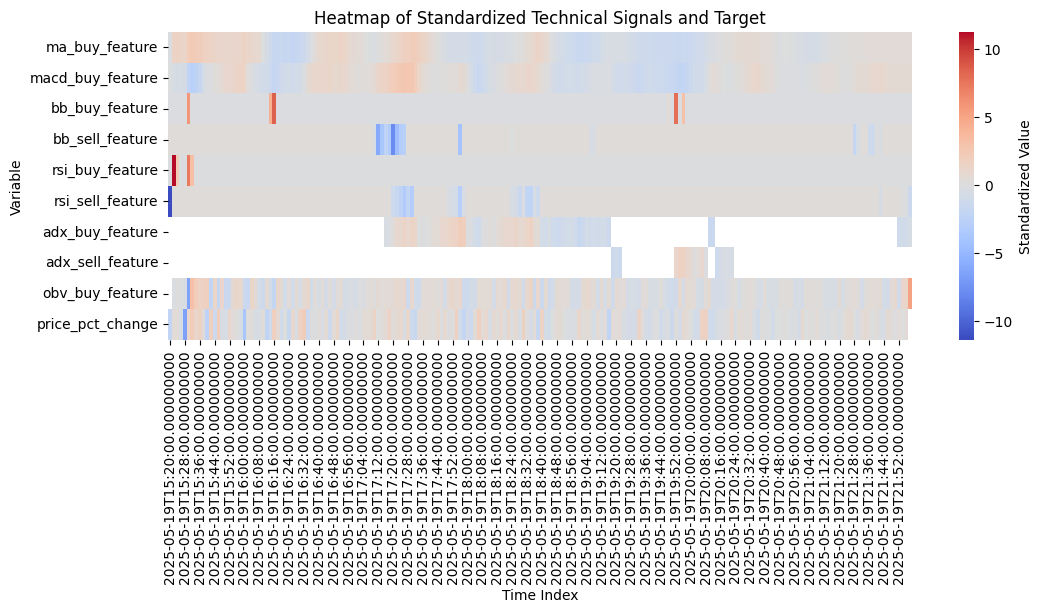

In [12]:
# ------------------------------------------
# (A) Create a Heatmap of the Time Evolution
# ------------------------------------------
# Transpose so that each row represents one variable (feature/target)
df_heatmap = df_norm.T

plt.figure(figsize=(12, 4))
sns.heatmap(df_heatmap, cmap='coolwarm', center=0, cbar_kws={'label': 'Standardized Value'})
plt.title('Heatmap of Standardized Technical Signals and Target')
plt.xlabel('Time Index')
plt.ylabel('Variable')
plt.show()


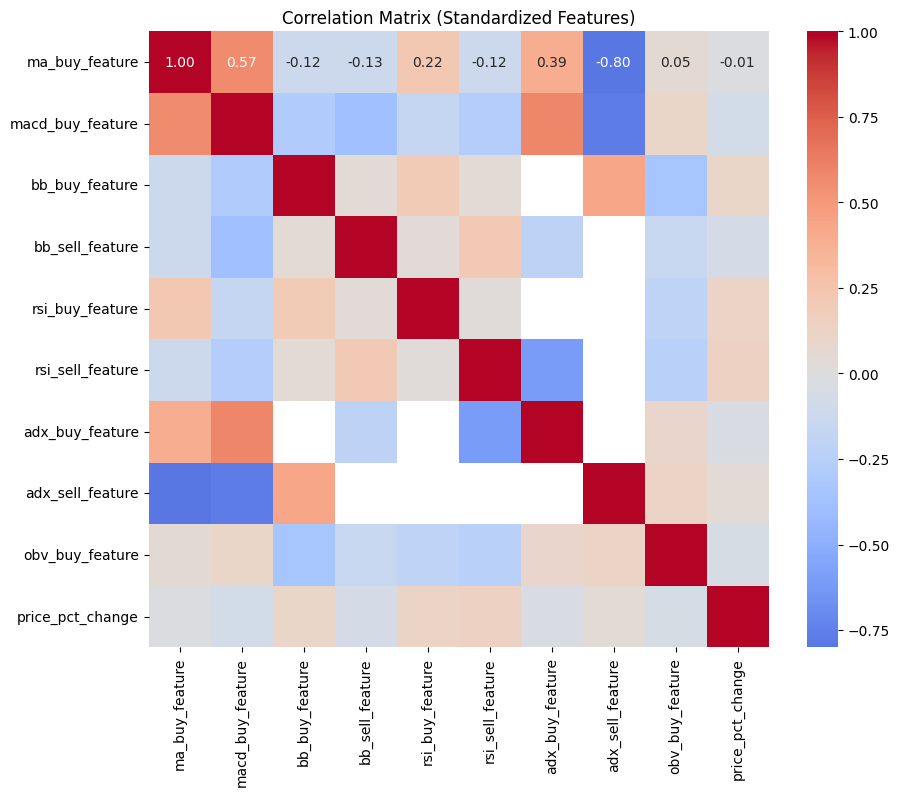

In [13]:

# ------------------------------------------
# (B) Create a Correlation Matrix
# ------------------------------------------
corr_matrix = df_norm.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Matrix (Standardized Features)')
plt.show()



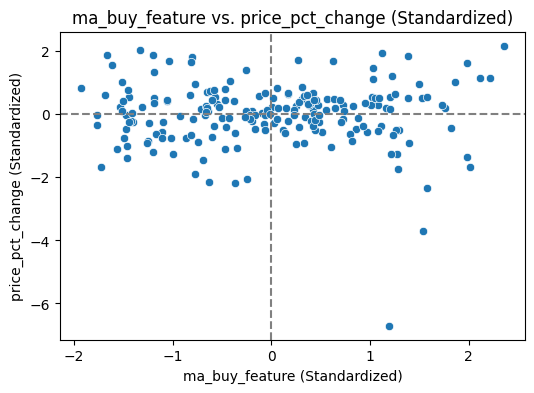

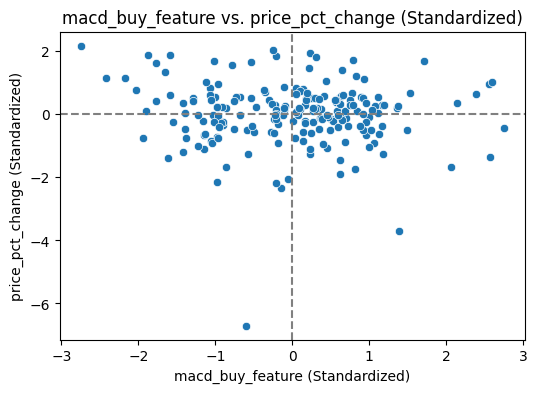

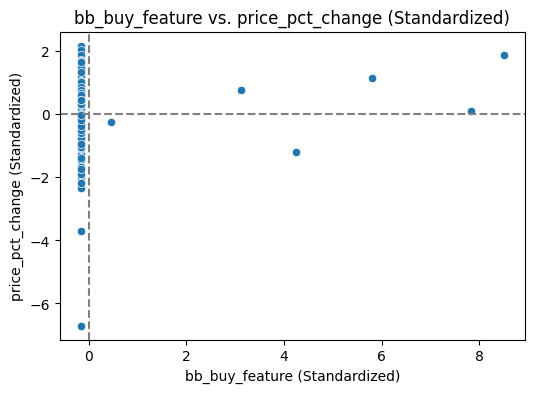

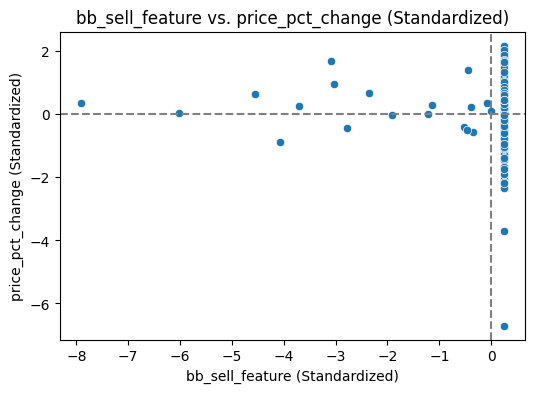

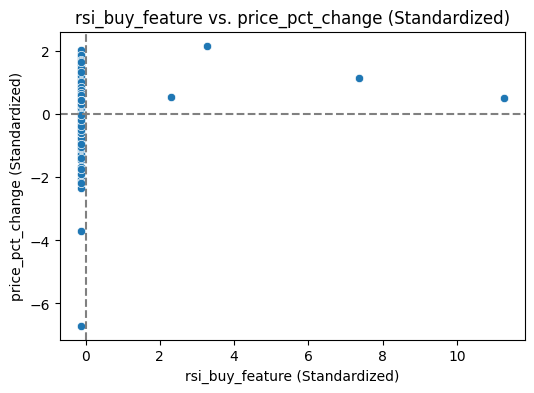

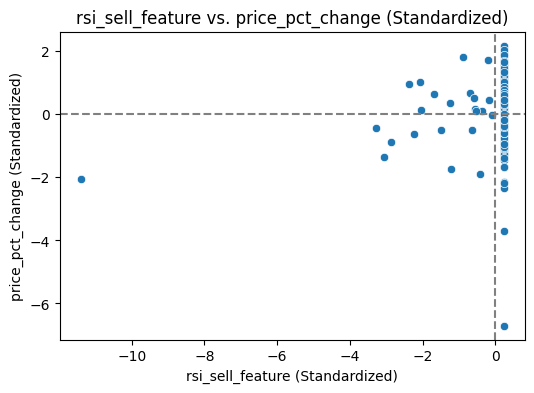

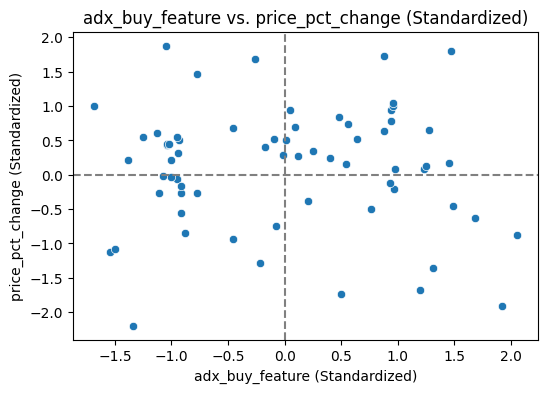

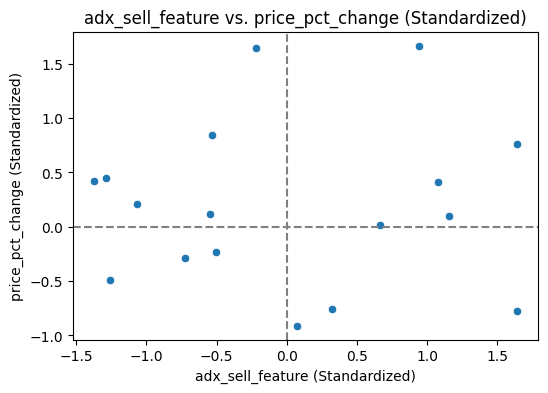

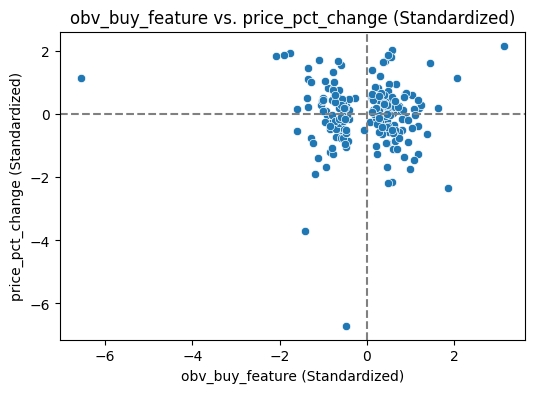

In [14]:
# ------------------------------------------
# (C) Scatter Plots for Each Feature vs. Target
# ------------------------------------------

for feature in feature_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df_norm[feature], y=df_norm[target_col].squeeze())
    plt.title(f'{feature} vs. price_pct_change (Standardized)')
    plt.xlabel(f'{feature} (Standardized)')
    plt.ylabel('price_pct_change (Standardized)')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.show()
